# Load dataset

In [7]:
# Libraries
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# https://huggingface.co/datasets/Nooha/cc_fraud_detection_dataset
ds = load_dataset("Nooha/cc_fraud_detection_dataset")
df = ds["train"].to_pandas() # convert to pandas dataframe

# # Uncomment to save raw data as csv file
# df.to_csv("../data/raw_data.csv", index = False)

In [9]:
# Split into train and test 
train_df = df.copy()
test_df = df.copy()

# Train: Jan 2021 - Apr 2023
train_df['trans_date'] = pd.to_datetime(train_df['trans_date'], errors = 'coerce')
train_df = train_df.loc[train_df['trans_date'] < '2023-05-01']

# Test: May 2023 - Dec 2023
test_df['trans_date'] = pd.to_datetime(test_df['trans_date'], errors = 'coerce')
test_df = test_df.loc[test_df['trans_date'] >= '2023-05-01']

# Check train and test data split
print(f"Train-test split size: {round(len(train_df)/len(df), 2) * 100}/{round(len(test_df)/len(df), 2)}")

Train-test split size: 75.0/0.25


## Data Preprocessing & Cleaning

In [10]:
def fraud_filter_fe(cols, df):
    return df[df['is_fraud'] == 1].groupby(cols).size().reset_index(name='fraud_count')

def calc_age(data):
    est = data['year'] - data['dob'].year
    if (data['trans_date'].month < data['dob'].month) or ((data['trans_date'].month == data['dob'].month) and (data['trans_date'].day < data['dob'].day)):
        return est - 1
    else:
        return est

In [11]:
# Apply data cleaning (similar to EDA)
def clean_df(df):

    # Convert date and time to appropriate data types
    df['dob'] = pd.to_datetime(df['dob'], errors = 'coerce') 
    df['trans_time'] = pd.to_datetime(df['trans_time'], format='%H:%M:%S')

    # Extract transaction time features
    week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df['hour'] = df['trans_time'].dt.hour
    df['day_of_week'] = pd.Categorical(df['trans_date'].dt.day_name(), categories=week_order, ordered=True)
    df['month'] = df['trans_date'].dt.to_period('M').dt.to_timestamp()

    df["trans_quarter"] = pd.PeriodIndex(df['month'], freq='Q')
    trans_quarter_order = df['trans_quarter'].sort_values().unique().tolist()
    df["trans_quarter"] = pd.Categorical(df['trans_quarter'], categories=trans_quarter_order, ordered=True)

    month_order = df['month'].sort_values().unique().tolist()
    df['month'] = pd.Categorical(df['month'], categories = month_order, ordered = True)

    df['year'] = df['trans_date'].dt.year
    df['trans_datetime'] = pd.to_datetime(df['trans_date'].dt.date.astype(str) + ' ' + df['trans_time'].dt.time.astype(str))

    # Sort df by ssn and transaction time
    df = df.sort_values(['ssn', 'trans_datetime'])

    # Calculate age at the time of the transaction (using function defined in `Data Preprocessing` section)
    df['age'] = df.apply(lambda x: calc_age(x), axis = 1)

    # Merge `city` and `state` columns
    df['city_state'] = df['city'] + ', ' + df['state']

    # Clean `merchant` feature
    df['merchant'] = df['merchant'].str.replace('fraud_','',regex=False)

    # Drop unused columns
    df = df.drop(columns=['first','last','cc_num', 'acct_num'])

    return df

train_df = clean_df(train_df)
test_df = clean_df(test_df)

# Feature Engineering

* running count of fraud (for customer) - prev_trans_fraud, count_fraud_7days, acc_fraud_count 
* running count of fraud (for merchant) - merchant_prev_trans_fraud, merchant_count_fraud_past7days, merchant_acc_fraud_count 
* holidays season's risk 
* indicator for whether category was visited in previous 30 days (or fewer if no data)
* interval between current transaction and previous transaction (in seconds)
* indicator for whether current transaction is customer's first/second transaction
* current interval / median interval of previous 30 days (or fewer if no data)
* current amount / median transaction amount of previous 30 days (or fewer if no data)
* indicator for whether current transaction is customer's first transaction for that category
* indicator for whether merchant is influential (top 5% merchants in terms of fraud rate in train data)


In [12]:
# for customers - prev_trans_fraud, count_fraud_7days, acc_fraud_count

def customer_fraud_record(df):
    df['prev_trans_fraud'] = 0

    for ssn, group in df.groupby('ssn'):
        prev_fraud = group['is_fraud'].shift(1)  # Use shift function in pandas to get their previous transaction 
        prev_fraud = prev_fraud.fillna(0)
        df.loc[group.index, 'prev_trans_fraud'] = prev_fraud.astype(int)

    df['count_fraud_7days'] = 0

    # Define function to count frauds in past 7 days for each customer group
    def count_fraud_past_7days(group):
        group = group.sort_values('trans_date')
        
        datetimes = group['trans_date'].values
        is_fraud = group['is_fraud'].values
        counts = np.zeros(len(group), dtype=int)
        
        for i in range(len(group)):
            current_time = datetimes[i]
            lookback_time = current_time - pd.Timedelta(days=7)
            
            time_mask = (datetimes < current_time) & (datetimes >= lookback_time)
            fraud_mask = is_fraud == 1
            
            counts[i] = np.sum(time_mask & fraud_mask)
        
        return counts

    # Apply the function to each customer group, update df
    result_series = df.groupby('ssn').apply(
        lambda x: pd.Series(
            count_fraud_past_7days(x),
            index=x.index
        )
    ).reset_index(level=0, drop=True)

    # Update the dataframe with the calculated counts
    df['count_fraud_7days'] = result_series

    # accumulative fraud count
    df['acc_fraud_count'] = df.groupby('ssn')['is_fraud'].transform(
        lambda x: x.cumsum().shift(1).fillna(0).astype(int)  # shift by 1 to exclude current transaction
    ) 

    return df

train_df = customer_fraud_record(train_df)
test_df = customer_fraud_record(test_df)


In [13]:
def merchant_fraud_history(df):
    # Sort df by merchant and transaction date
    df = df.sort_values(['merchant', 'trans_date'])

    # merchant_prev_trans_fraud
    df['merchant_prev_trans_fraud'] = 0

    for merchant, group in df.groupby('merchant'):
        prev_fraud = group['is_fraud'].shift(1)
        prev_fraud = prev_fraud.fillna(0)
        df.loc[group.index, 'merchant_prev_trans_fraud'] = prev_fraud.astype(int)

    # checking for fraud in past 7 days for merchant
    df['merchant_count_fraud_past7days'] = 0


    def merchant_count_fraud_past_7days(group):
        # sorted by transaction date
        group = group.sort_values('trans_date')
        
        datetimes = group['trans_date'].values
        is_fraud = group['is_fraud'].values
        counts = np.zeros(len(group), dtype=int)
        
        for i in range(len(group)):
            current_time = datetimes[i]
            lookback_time = current_time - pd.Timedelta(days=7)
            
            time_mask = (datetimes < current_time) & (datetimes >= lookback_time)
            fraud_mask = is_fraud == 1
            
            counts[i] = np.sum(time_mask & fraud_mask)
        
        return counts

    # Apply the function to each merchant group, update df
    result_series = df.groupby('merchant').apply(
        lambda x: pd.Series(
            merchant_count_fraud_past_7days(x),
            index=x.index
        )
    ).reset_index(level=0, drop=True)

    
    df['merchant_count_fraud_past7days'] = result_series

    # Merchant accumulative fraud
    df['merchant_acc_fraud_count'] = df.groupby('merchant')['is_fraud'].transform(
        lambda x: x.cumsum().shift(1).fillna(0).astype(int) #shift by 1 to exclude current trans
    )

    return df

train_df = merchant_fraud_history(train_df)
test_df = merchant_fraud_history(test_df)

In [14]:
# peak spending period's risk 
def calculate_risk_score(df):
    """
    Risk Scoring Criteria:
    - High Risk (2): Nov 1st - Jan 7th (holiday period)
    - Medium Risk (1): 
      * June - August
      * Two weeks before November (Oct 18th - Oct 31st)
      * One week after Jan 7th (Jan 8th - Jan 14th)
    - Low Risk (0): All other periods
    """
    def _risk_score(month, day):
        # High-risk period (Holiday season)
        if (month.month == 11 and day >= 1) or \
           (month.month == 12) or \
           (month.month == 1 and day <= 7):
            return 2
        
        # Medium-risk periods (Summer months, June - August)
        if month.month in [6, 7, 8]:
            return 1
        
        # Two weeks before November (Oct 18 - Oct 31)
        if month.month == 10 and 18 <= day <= 31:
            return 1
        
        # One week after Jan 7th (Jan 8 - Jan 14)
        if month.month == 1 and 8 <= day <= 14:
            return 1
        
        return 0

    return df.apply(lambda row: _risk_score(row['month'], row['trans_date'].day), axis=1)

train_df['transaction_risk_score'] = calculate_risk_score(train_df)
test_df['transaction_risk_score'] = calculate_risk_score(test_df)

In [15]:
def calculate_hourly_risk_score(df, hour_col='hour'):
    # Calculate fraud counts and total transactions by hour
    hourly_stats = df.groupby(hour_col).agg(
        fraud_count=('is_fraud', 'sum'),
        transaction_count=('is_fraud', 'count')
    )
    # Convert to dictionaries
    fraud_counts = hourly_stats['fraud_count'].to_dict()
    total_transactions = hourly_stats['transaction_count'].to_dict()
    
    # Calculate fraud rates and thresholds; high risk (2), medium risk (1), and low risk (0)
    fraud_rates = {h: (fraud_counts.get(h, 0) / total_transactions.get(h, 1)) * 100 for h in range(24)}
    rates = np.array(list(fraud_rates.values()))
    high_threshold = np.percentile(rates, 90)
    medium_threshold = np.percentile(rates, 60)
 
    # Create risk mapping
    risk_map = {
        h: 2 if rate >= high_threshold else
           1 if rate >= medium_threshold else
           0
        for h, rate in fraud_rates.items()
    }

    return df[hour_col].map(risk_map).astype(int)

train_df['hourly_risk_score'] = calculate_hourly_risk_score(train_df)
test_df['hourly_risk_score'] = calculate_hourly_risk_score(test_df)

In [16]:
def categories_visited(df, days):
    # Sort transactions chronologically for each customer
    df = df.sort_values(['ssn', 'trans_date', 'unix_time'])
    rolling_categories = []

    # Group by ssn and loop through
    for ssn, group in df.groupby('ssn'):
        dates = group['trans_date'].values
        categories = group['category'].values
        visited_categories = []

        # For each transaction, get the categories visited in the past 30 days
        for i in range(len(group)):
            window_start = dates[i] - np.timedelta64(days, 'D')
            window_period = (dates < dates[i]) & (dates >= window_start)
            valid_interval = categories[window_period]
            valid_interval = valid_interval[~pd.isnull(valid_interval)]
            visited_categories.append({value: 1 for value in valid_interval})
            
        rolling_categories.append(pd.Series(visited_categories, index=group.index))
        
    # Combine rolling categories from all groups
    df['rolling_categories'] = pd.concat(rolling_categories).sort_index()
  
    # Create indicator for whether current transaction category has been visited before
    df['visited_cat'] = [int(bool(d.get(c))) if isinstance(d, dict) else None for d, c in zip(df['rolling_categories'], df['category'])]
    # Drop 'rolling_categories' column
    df = df.drop(['rolling_categories'], axis = 1)
    
    return df

train_df = categories_visited(train_df, 30)
test_df = categories_visited(test_df, 30)

In [17]:
def city_population_size(df):
    city_population_bin = [0,100000, 350000, 1000000, np.inf]

    labels = [0,1,2,3] # 0: tiny, 1: small, 2: medium, 3: large metros

    df.loc[:, "city_population_class"] = pd.cut(df.loc[:, "city_pop"], bins = city_population_bin, labels = labels)
    return df

train_df = city_population_size(train_df)
test_df = city_population_size(test_df)

In [18]:
def transaction_interval(df, days):
    # Find the interval between transactions
    freq_purchases = df.sort_values(['ssn', 'unix_time'])[['ssn', 'trans_num', 'unix_time', 'trans_date']]
    freq_purchases['prev_unix_time'] = freq_purchases.groupby('ssn').shift(1)['unix_time']
    freq_purchases['interval'] = freq_purchases['unix_time'] - freq_purchases['prev_unix_time']
    freq_purchases = freq_purchases.sort_values(['ssn', 'trans_date', 'unix_time'])

    # Flag first/second purchases with no intervals
    freq_purchases['first_second_purchase'] = freq_purchases['interval'].isna().astype(int)

    rolling_median = []

    # Group by ssn and loop through
    for ssn, group in freq_purchases.groupby('ssn'):
        dates = group['trans_date'].values
        intervals = group['interval'].values
        medians = np.zeros(len(group))

        # For each transaction, get the median interval of all transactions in past 30 days
        for i in range(len(group)):
            window_start = dates[i] - np.timedelta64(days, 'D')
            window_period = (dates < dates[i]) & (dates >= window_start)
            valid_interval = intervals[window_period]
            valid_interval = valid_interval[~np.isnan(valid_interval)]
            medians[i] = np.median(valid_interval) if len(valid_interval) > 0 else 0
        
        rolling_median.append(pd.Series(medians, index=group.index))
    
    # Combine rolling medians from all groups and add to df
    df['rolling_median_interval'] = pd.concat(rolling_median).sort_index()

    # Add 'interval' and 'first_second_purchase' columns to main df
    df = pd.merge(df, freq_purchases[['trans_num', 'interval', 'first_second_purchase']], how = 'left', on = 'trans_num')
    # Impute missing intervals as 0
    df['interval'] = df['interval'].fillna(0)

    # Calculate the percentage deviation of each transaction's interval from the user's median interval across previous days
    df['interval_deviation'] = round((df['interval'] - df['rolling_median_interval']) / df['rolling_median_interval'], 2)

    # For first purchases and those with NA rolling median interval, impute interval_deviation with 0
    df.loc[df['rolling_median_interval'] == 0, 'interval_deviation'] = 0
    df.loc[df['first_second_purchase'] == 1, 'interval_deviation'] = 0

    # Drop 'rolling_median_interval' column
    df = df.drop(['rolling_median_interval'], axis = 1)

    return df

train_df = transaction_interval(train_df, 30)
test_df = transaction_interval(test_df, 30)

In [19]:
def median_trans_amt(df, days):

    # Create ssn_cat column to represent unique ssn and category
    df['ssn_cat'] = df['ssn'].astype(str) + ' ' + df['category']
    df = df.sort_values(['ssn_cat', 'trans_date', 'unix_time'])

    rolling_median = []

    # Group by ssn_cat and loop through
    for _, group in df.groupby('ssn_cat'):
        dates = group['trans_date'].values
        amts = group['amt'].values
        medians = np.zeros(len(group))

        # Get median transaction amount of past 30 days 
        for i in range(len(group)):
            window_start = dates[i] - np.timedelta64(days, 'D')
            window_period = (dates < dates[i]) & (dates >= window_start)
            valid_interval = amts[window_period]
            valid_interval = valid_interval[~np.isnan(valid_interval)]
            medians[i] = np.median(valid_interval) if len(valid_interval) > 0 else np.nan
        
        rolling_median.append(pd.Series(medians, index=group.index))
        
    # Combine rolling medians from all groups
    df['cat_rolling_median'] = pd.concat(rolling_median).sort_index()

    # Impute missing customer-specific category median with 0 and create column to indicate that this is their first purchase in this category
    df['category_first_purchase'] = df['cat_rolling_median'].isna().astype(int)
    df['cat_rolling_median'] = df['cat_rolling_median'].fillna(0)
    
    # Calculate percentage deviation of each transaction's amount to the user's rolling mean transaction amount for that category
    df['amt_deviation'] = round((df['amt'] - df['cat_rolling_median']) / df['cat_rolling_median'], 2)
    # Impute `amt_deviation` to 0 for first purchases and those with cat_rolling_median = 0
    df.loc[df['category_first_purchase'] == 1, 'amt_deviation'] = 0
    df.loc[df['cat_rolling_median'] == 0, 'amt_deviation'] = 0
    

    # Drop 'cat_rolling_median' and 'ssn_cat' columns
    df = df.drop(['cat_rolling_median', 'ssn_cat'], axis = 1)

    return df

train_df = median_trans_amt(train_df, 30)
test_df = median_trans_amt(test_df, 30)

In [20]:
def identify_influential_merchants(df, df_analyse=train_df):
    merchant_fraud_count = fraud_filter_fe('merchant', df_analyse).sort_values(by='fraud_count', ascending=False)
    n = round(merchant_fraud_count.shape[0] * 0.05)

    cutoff_count = merchant_fraud_count.iloc[n]['fraud_count']
    influential_merchants = merchant_fraud_count[merchant_fraud_count['fraud_count'] >= cutoff_count]
    df['influential_merchant'] = df['merchant'].isin(influential_merchants['merchant']).astype(int)

    return df

train_df = identify_influential_merchants(train_df)
test_df = identify_influential_merchants(test_df)

## Check for multi-collinearity

We will drop the `amt_deviation` and `category_first_purchase` columns to reduce multi-collinearity.

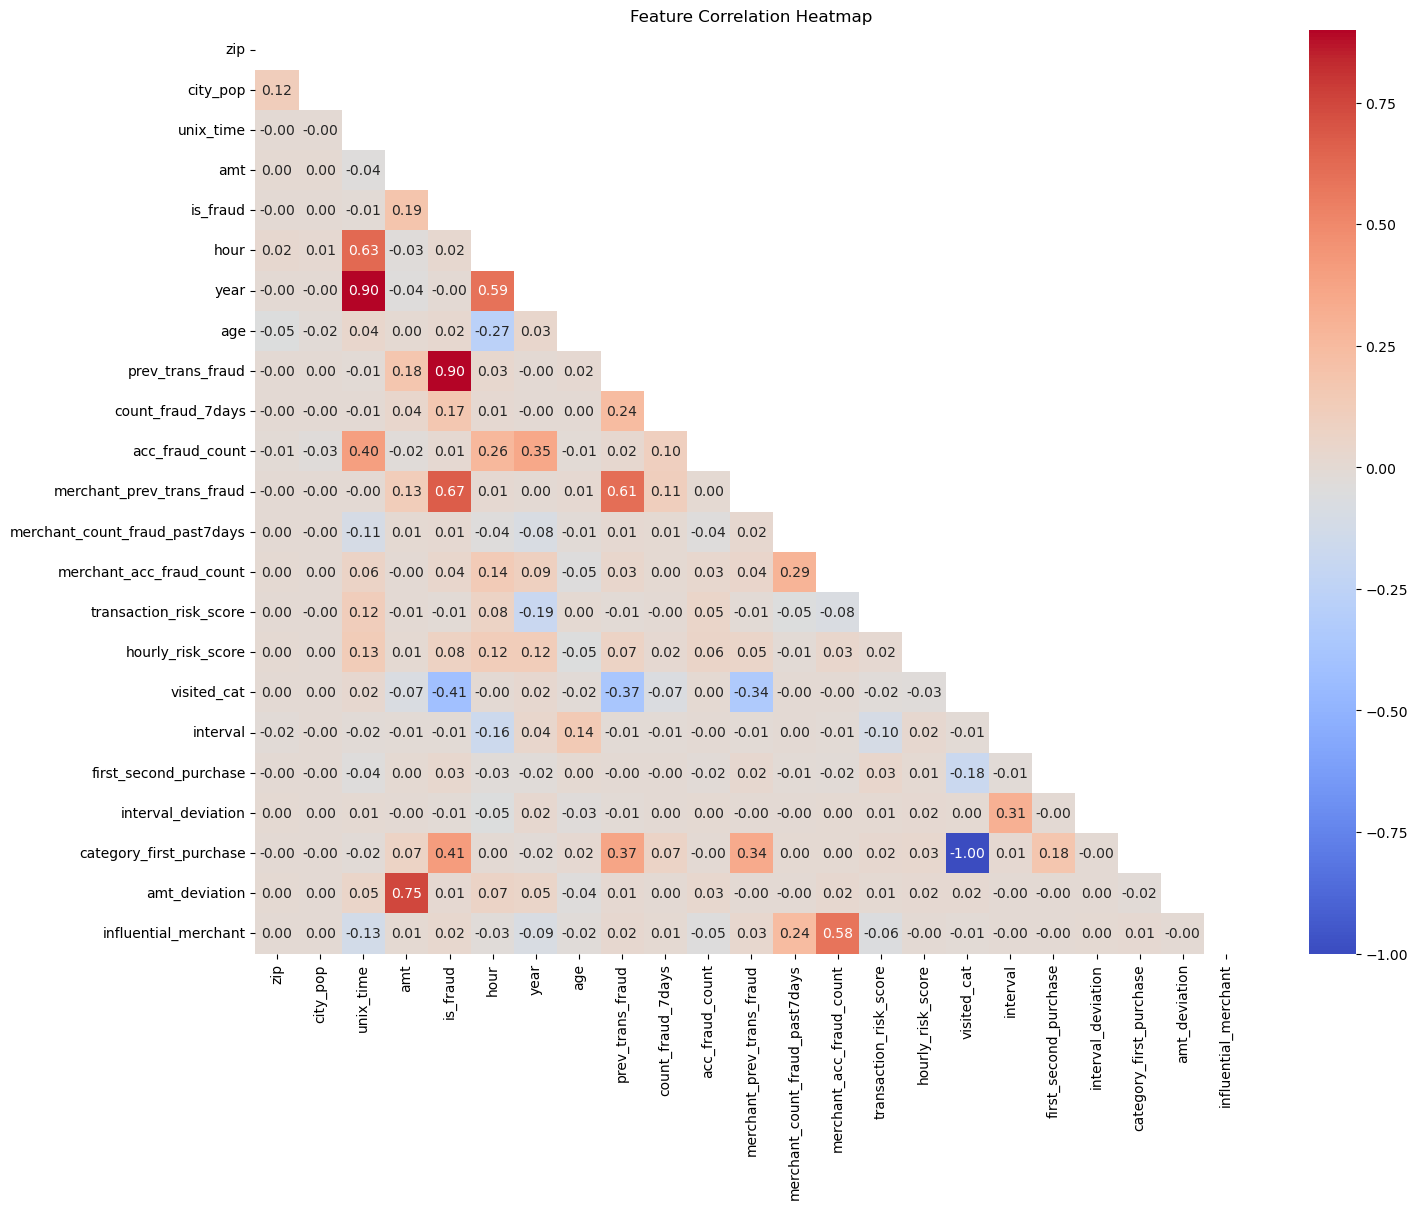

In [21]:
# Correlation heat map
df_numeric = train_df.select_dtypes(include=['number'])

# Create mask for upper triangle
mask = np.triu(df_numeric.corr())  

# Create the correlation heatmap
plt.figure(figsize=(16, 12))  # Larger figure
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title("Feature Correlation Heatmap")
plt.show()  


In [22]:
# Drop columns that will not be used in model training or have high multi-collinearity
cols_to_drop = ['ssn', 'trans_date', 'city', 'city_state', 'dob', 'trans_time', 'unix_time', 'trans_num', 'trans_datetime', 'merchant', 'category_first_purchase', 'amt_deviation']

train_df = train_df.drop(cols_to_drop, axis = 1)
test_df = test_df.drop(cols_to_drop, axis = 1)

In [23]:
# Uncomment to save a copy of prepared train and test dfs into csv files
# train_df.to_csv("../../data/train_data.csv", index = False)
# test_df.to_csv("../../data/test_data.csv", index = False)